In [ ]:
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
import io
from math import ceil
from dataclasses import dataclass
import sys
import pandas as pd

TO_EPOCH = 631_152_000  # seconds between Unix epoch and Campbell epoch

csci_types = ["FP2","FP2","FP2","FP2","FP2","FP2","IEEE4B","IEEE4B","IEEE4B","IEEE4B","FP2","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","UINT2","UINT2","UINT2","UINT2","UINT2","UINT2","UINT2","UINT2","UINT2"]
names = ["BattV_Min","PTemp_C","TA","VP","RH","PA","SW_IN","SW_OUT","LW_IN","LW_OUT","ALB","NETRAD","NetSw","NetLw","LW_IN_Uncorr","LW_OUT_Uncorr","CNR4_Tbody_C","T_CANOPY","SI111_Tbody_C","PPFD","Judd_Ta_C","Judd_Dist","D_SNOW","WS","WD","TSN(1)","TSN(2)","TSN(3)","TSN(4)","TSN(5)","TSN(6)","TSN(7)","TSN(8)","TSN(9)","TSN(10)","TSN(11)","TSN(12)","TSN(13)","TSN(14)","VWC(1,1)","VWC(1,2)","VWC(1,3)","VWC(2,1)","VWC(2,2)","VWC(2,3)","VWC(3,1)","VWC(3,2)","VWC(3,3)","TS(1,1)","TS(1,2)","TS(1,3)","TS(2,1)","TS(2,2)","TS(2,3)","TS(3,1)","TS(3,2)","TS(3,3)","EC(1,1)","EC(1,2)","EC(1,3)","EC(2,1)","EC(2,2)","EC(2,3)","EC(3,1)","EC(3,2)","EC(3,3)","VWCCounts(1,1)","VWCCounts(1,2)","VWCCounts(1,3)","VWCCounts(2,1)","VWCCounts(2,2)","VWCCounts(2,3)","VWCCounts(3,1)","VWCCounts(3,2)","VWCCounts(3,3)","TEROS12_Diag(1,1)","TEROS12_Diag(1,2)","TEROS12_Diag(1,3)","TEROS12_Diag(2,1)","TEROS12_Diag(2,2)","TEROS12_Diag(2,3)","TEROS12_Diag(3,1)","TEROS12_Diag(3,2)","TEROS12_Diag(3,3)"]

non_timestamped_record_interval = 300.0  # s
table_nlines_expected = 316
frame_time_resolution = 100e-6  # s
ring_record_frame_number = 0  # not applicable here
removal_time_frame_number = 0  # not applicable here
validation_stamp = 43077

header_nbytes = 12
footer_nbytes = 4
line_nbytes = 222
frame_nbytes = 904

data_nbytes = frame_nbytes - header_nbytes - footer_nbytes
data_line_nfields = len(csci_types)
data_nlines = data_nbytes // line_nbytes

table_nframes_expected = ceil(table_nlines_expected / data_nlines)

In [ ]:
# time_offset = cursor.read_i32_le() + TO_EPOCH
# subseconds = cursor.read_i32_le()
# timestamp = float(time_offset) + (float(subseconds) * frame.frame_time_res)
# beg_record = cursor.read_i32_le() if frame.frame_type == FrameType.TOB3 else 0
header_dtype = np.dtype([('time_offset', '<i4'), ('subseconds', '<i4'), ('beg_record', '<i4')])
# tob2  np.dtype([('time_offset', '<i4'), ('subseconds', '<i4')])

footer_dtype = np.dtype([('footer', '<i4')])

dtypes = []
for name, csci_type in zip(names, csci_types):
    match csci_type:
        case "FP2":
            dtypes.append((name, '>u2'))
            # still need to do bit manipulation to convert it to a float
        case "IEEE4B":
            dtypes.append((name, '>f4'))
        case "UINT2":
            dtypes.append((name, '>u2'))
data_dtype = np.dtype(dtypes)


4

In [ ]:
@dataclass(frozen=True, slots=True)
class Footer:
    offset: int
    file_mark: bool
    ring_mark: bool
    empty_frame: bool
    minor_frame: bool
    validation: int
def parse_footer(footer_bytes):
    content = int.from_bytes(footer_bytes[-4:], "little", signed=True)
    return Footer(
        offset = content & 0x7FF,
        file_mark = bool((content >> 11) & 0x1),
        ring_mark = bool((content >> 12) & 0x1),
        empty_frame = bool((content >> 13) & 0x1),
        minor_frame = bool((content >> 14) & 0x1),
        validation = (content >> 16) & 0xFFFF,
    )


In [ ]:
headers_raw = [b'\x00'*header_nbytes]*table_nframes_expected
data_raw = [b'\x00'*data_nbytes]*table_nframes_expected
footers_raw = [Footer(0, False, False, False, False, 0)]*table_nframes_expected
mask = np.zeros(table_nlines_expected, dtype=bool)  # mask by *line* not frame

In [156]:
input_buff = open("../tests/tob3/23313_Site4_300Sec5.dat", "rb")
# with open("../tests/tob3/23313_Site4_300Sec5_manually_corrupted.dat", "wb") as fout:
#     fout.write(input_buff.read(30_000))
# input_buff = open("../tests/tob3/23313_Site4_300Sec5_manually_corrupted.dat", "rb")
try:
    # read header, but don't parse because we already have that info hardcoded for this test case
    for _ in range(6):
        input_buff.readline()
    
    data_start_pos = input_buff.tell()

    final_frame = 0
    for frame in range(table_nframes_expected):
        # validate the footer before proceeding
        input_buff.seek(header_nbytes + data_nbytes, 1)
        
        footer_bytes = input_buff.read(footer_nbytes)

        footer = parse_footer(footer_bytes)
        if footer.validation not in (validation_stamp, int(0xFFFF ^ validation_stamp)):
            if input_buff.tell() - data_start_pos != (frame + 1) * frame_nbytes:
                sys.stderr.write(f" *** Warning: corrupt data frame encountered at position {input_buff.tell()}B. Further data in this file will not be processed.\n")
                sys.stderr.flush()
                break
            continue

        # return to beginning of the frame to reader header and data once validation is successful
        input_buff.seek(-frame_nbytes, 1)  # seek back to the beginning of the frame

        header_bytes = input_buff.read(header_nbytes)
        data_bytes = input_buff.read(data_nbytes)

        input_buff.seek(footer_nbytes, 1)  # seek past the footer to the next frame
        if input_buff.tell() - data_start_pos != (frame + 1) * frame_nbytes:
            sys.stderr.write(f" *** Warning: corrupt data frame encountered at position {input_buff.tell()}B. Further data in this file will not be processed.\n")
            sys.stderr.flush()
            break
            
        # handle minor/partial frames by marking the missing lines in a mask
        if footer.minor_frame:
            missing_lines = footer.offset/line_nbytes
            if missing_lines % 1 != 0:
                sys.stderr.write(f" *** Warning: corrupt frame with non-integer number of missing lines ({missing_lines}) encountered at position {input_buff.tell()}B. Further data in this file will not be processed.\n")
                sys.stderr.flush()
                break
            missing_lines = int(missing_lines)
            mask[(frame+1)*data_nlines - missing_lines:(frame+1)*data_nlines] = True

        headers_raw[frame] = header_bytes
        data_raw[frame] = data_bytes
        footers_raw[frame] = footer
        
        final_frame = frame + 1  # final frame is the last successfully validated one

finally:
    input_buff.close()

In [152]:
def decode_fp2(u16):
    u16 = u16.astype(np.uint16, copy=False)
    sign = (u16 >> 15) & 0x1
    exponent = (u16 >> 13) & 0x3
    mantissa = u16 & 0x1FFF

    # Campbell FP2 NaN encodings
    is_nan = ((exponent == 0) & (mantissa == 8191)) | ((sign == 1) & (exponent == 0) & (mantissa == 8190))

    # (-1)^sign * 10^(-exponent) * mantissa
    result = ((-1.0) ** sign) * (10.0 ** (-exponent.astype(np.float32))) * mantissa.astype(np.float32)
    result = np.where(is_nan, np.nan, result).astype(np.float32)
    return result

data = structured_to_unstructured(np.frombuffer(b''.join(data_raw[:final_frame]), dtype=data_dtype), dtype=np.float32)
# Convert FP2 fields in place (or make a new dict/structured array if you prefer)
for col, t in enumerate(csci_types):
    if t == "FP2":
        data[:, col] = decode_fp2(data[:, col])
data[mask[:final_frame*data_nlines]] = np.nan

In [161]:
footers = np.array([
    [foot.offset, foot.file_mark, foot.ring_mark, foot.empty_frame, foot.minor_frame, foot.validation]
    for foot in footers_raw[:final_frame]
])

In [180]:
headers = structured_to_unstructured(np.frombuffer(b''.join(headers_raw[:final_frame]), dtype=header_dtype))

timestamps = np.empty(final_frame*data_nlines, dtype=np.float64)
records = np.empty(final_frame*data_nlines, dtype=np.int32)
for i in range(final_frame):
    time_offset = headers[i, 0] + TO_EPOCH
    subseconds = headers[i, 1]
    beg_timestamp = float(time_offset) + (float(subseconds) * frame_time_resolution)
    beg_record = headers[i, 2]

    timestamps[i*data_nlines:(i+1)*data_nlines] = np.arange(
        beg_timestamp, beg_timestamp + data_nlines*non_timestamped_record_interval, 
        non_timestamped_record_interval
    )
    records[i*data_nlines:(i+1)*data_nlines] = np.arange(beg_record, beg_record + data_nlines)

In [195]:
df = pd.DataFrame(
    np.concatenate((records[:, None], data), axis=1),
    columns = ["RECORD"] + names,
    index=pd.to_datetime(timestamps, unit='s')
)
df.index.rename("TIMESTAMP", inplace=True)
df = df.sort_index()
df

,RECORD,BattV_Min,PTemp_C,TA,VP,RH,PA,SW_IN,SW_OUT,LW_IN,...,"VWCCounts(3,3)","TEROS12_Diag(1,1)","TEROS12_Diag(1,2)","TEROS12_Diag(1,3)","TEROS12_Diag(2,1)","TEROS12_Diag(2,2)","TEROS12_Diag(2,3)","TEROS12_Diag(3,1)","TEROS12_Diag(3,2)","TEROS12_Diag(3,3)"
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2024-05-30 00:05:00,753.0,13.150000,3.270,4.2,0.609,0.736,72.820000,-0.034871,5.315106,384.164581,...,2583.139893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-30 00:10:00,754.0,13.150000,3.160,4.4,0.606,0.723,72.820000,-1.275779,3.990437,385.073914,...,2582.459961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-30 00:15:00,755.0,13.139999,3.079,4.9,0.614,0.709,72.809998,0.188588,6.093083,388.660889,...,2582.830078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-30 00:20:00,756.0,13.139999,3.046,4.9,0.606,0.698,72.809998,-1.567557,4.384080,391.117004,...,2582.520020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-30 00:25:00,757.0,13.139999,3.026,4.8,0.616,0.714,72.809998,-1.459579,4.470946,392.341034,...,2580.939941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30 23:40:00,1036.0,13.130000,0.246,0.7,0.422,0.658,72.900002,-3.154284,3.130440,372.853027,...,2582.030029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-30 23:45:00,1037.0,13.130000,0.136,0.6,0.414,0.648,72.900002,-2.888534,3.707096,371.977966,...,2581.840088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-30 23:50:00,1038.0,13.120000,0.036,0.4,0.415,0.660,72.900002,-2.885578,3.064938,370.779480,...,2581.580078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
def decode_fp2(u16):
    u16 = u16.astype(np.uint16, copy=False)
    sign = (u16 >> 15) & 0x1
    exponent = (u16 >> 13) & 0x3
    mantissa = u16 & 0x1FFF

    # Campbell FP2 NaN encodings
    is_nan = ((exponent == 0) & (mantissa == 8191)) | ((sign == 1) & (exponent == 0) & (mantissa == 8190))

    # (-1)^sign * 10^(-exponent) * mantissa
    result = ((-1.0) ** sign) * (10.0 ** (-exponent.astype(np.float32))) * mantissa.astype(np.float32)
    result = np.where(is_nan, np.nan, result).astype(np.float32)
    print(u16, result)
    return result

dtypes = []
for name, csci_type in zip(names, csci_types):
    match csci_type:
        case "FP2":
            dtypes.append((name, '>u2'))
            # still need to do bit manipulation to convert it to a float
        case "IEEE4B":
            dtypes.append((name, '>f4'))
        case "UINT2":
            dtypes.append((name, '>u2'))
dtype = np.dtype(dtypes)


raw_struct = np.frombuffer(raw, dtype=dtype).copy()

# Convert FP2 fields in place (or make a new dict/structured array if you prefer)
for name, csci_type in zip(names, csci_types):
    if csci_type == "FP2":
        raw_struct[name] = decode_fp2(raw_struct[name])
# Now you can stack to 2D if needed
data_numpy = structured_to_unstructured(raw_struct)

[17699 17699 17698 17698] [13.15     13.15     13.139999 13.139999]
[27846 27736 27655 27622] [3.2700002 3.16      3.0790002 3.0460002]
[28776 28976 29476 29476] [4.2000003 4.4       4.9       4.9      ]
[25185 25182 25190 25182] [0.609 0.606 0.614 0.606]
[25312 25299 25285 25274] [0.73600006 0.72300005 0.70900005 0.698     ]
[23666 23666 23665 23665] [72.82 72.82 72.81 72.81]
[40958 40958 40958 40958] [nan nan nan nan]
[26851 26935 27156 27398] [2.275     2.3590002 2.5800002 2.822    ]
[26304 26405 26420 26176] [1.728     1.8290001 1.8440001 1.6      ]
[27700 27823 28067 28259] [3.124     3.2470002 3.4910002 3.683    ]
[24576 24576 24576 24576] [0. 0. 0. 0.]
[28591 28094 29093 28595] [4.0150003 3.5180001 4.517     4.019    ]
[24990 24990 24990 24990] [0.41400003 0.41400003 0.41400003 0.41400003]
[40958 40958 40958 40958] [nan nan nan nan]
[25012 24801 25349 25304] [0.43600002 0.22500001 0.77300006 0.72800004]
[10738 10488 10709 10617] [254.6 229.6 251.7 242.5]
[40958 40958 40958 40958

/var/folders/h1/hhwj_15n5pjc0cht5mmph_y40000gn/T/ipykernel_52644/2589504807.py:34: RuntimeWarning: invalid value encountered in cast
  raw_struct[name] = decode_fp2(raw_struct[name])


In [ ]:
# TODO
# Iterate through file
# Extract the raw bytes for the header, data, and footer
# Process the footer to confirm the checksum
# If valid, stream the header and data bytes to separate buffers
# Use numpy to parse the data buffer according to the defined structure
# Don't worry about the header just yet

array([5., 5., 5., 5.], dtype=float32)

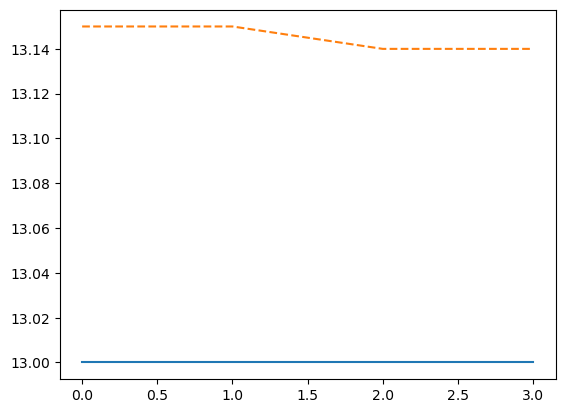

In [69]:
import matplotlib.pyplot as plt

plt.plot(data_numpy[:, 0])
plt.plot(data_python[:, 0], linestyle='dashed')